# Simple CCZ4 Finite Volume code
 
A solver of the Einstein equations that uses the original ExaHyPE FORTRAN kernels.

In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use and we have to give it a name. There are a few more options that we omit here, i.e. we use the defaults.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "ccz4"], "ccz4" )

## Configuring the solver

Our first step is to use a Finite Volumes solver. I write down all the unknowns first. I'll use this dictionary later to access variables symbolically. For the time being, I just define this map and then count the number of unknowns. This total count is something I really need to configure my solver.

In [4]:
unknowns = {
  "G":6,
  "K":6,
  "theta":1,
  "Z":3,
  "lapse":1,
  "shift":3,
  "b":3,
  "dLapse":3,
  "dxShift":3,
  "dyShift":3,
  "dzShift":3,
  "dxG":6,
  "dyG":6,
  "dzG":6,
  "traceK":1,
  "phi":1,
  "P":3,
  "K0":1,
  "rho":1,
  "u":3,
  "p":1
}

number_of_unknowns = 0
for i in unknowns:
  number_of_unknowns += unknowns[i]
print( "number of unknowns=", number_of_unknowns )

number of unknowns= 64


The solver itself is a simple Finite Volume solver with fixed time stepping. I use the enclave solver variant which is a solver nuance that is particuarly good on large shared memory architectures. Our PDE is expressed solely in a nonconservative formulation. I therefore can switch the flux term off.

In [5]:
patch_size          = 6
auxiliary_variables = 0
time_step_size      = 0.001
max_h               = 0.4
min_h               = 0.4

my_solver = exahype2.solvers.fv.GenericRusanovFixedTimeStepSizeWithEnclaves(
  "CCZ4", patch_size, number_of_unknowns, auxiliary_variables, min_h, max_h, time_step_size
)


project.add_solver(my_solver)

I next inject homogeneous Neumann boundary conditions:

In [6]:
import exahype2.sympy

pde = exahype2.sympy.PDE(unknowns=number_of_unknowns,auxiliary_variables=0,dimensions=3)

my_solver.set_implementation(
  boundary_conditions=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  flux=exahype2.solvers.fv.PDETerms.None_Implementation,
  ncp=exahype2.solvers.fv.PDETerms.User_Defined_Implementation,
  source_term=exahype2.solvers.fv.PDETerms.User_Defined_Implementation
)   


## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [7]:
build_mode = peano4.output.CompileMode.Asserts
#build_mode = peano4.output.CompileMode.Release

dimensions = 3
end_time = 4.0
snapshots = time_step_size*20
    
project.set_global_simulation_parameters(
  dimensions,               # dimensions
  [-0.5, -0.5, -0.5],  [1.0, 1.0, 1.0],
  end_time,                 # end time
  0.0, snapshots,   # snapshots
  [True,True,True]          # Periodic BC
)

## Generate a Peano 4 project

This is exactly the same as for Euler: We ask the ExaHyPE 2 front-end to give us a Peano project.

In [8]:
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is mpicxx
used Fortran compiler is gfortran


A "big" difference to Euler is that we now have some external Fortran files. Usually, we take the default settings when we invoke the Fortran compiler. Default is the stuff given to us by Peano's configure. There's however the opportunity to add further flags manually. I use this here as the astro code requies some bespoke defines. Also, I need the -cpp flag. Otherwise the preprocessor macros are not taken into account properly and my Intel compiler terminates.
- The option "-DGLMROT" can be added to enable curl cleaning, however this requires additional variables. Be sure to add these before enabling this option.
- With GNU, I have used 
<pre>
./configure  FC="gfortran" CXX="g++" LDFLAGS="-L/opt/vtk/lib64 -L/opt/intel/tbb/lib/intel64/gcc4.8 -ltbb_debug -lpthread" CXXFLAGS="-I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include"   --enable-exahype --enable-loadbalancing-toolbox --with-multithreading=omp
</pre>
for this one on my system.
- With Intel, I used
<pre>
./configure FC="ifort" CXX="icpc" LDFLAGS="-L/opt/vtk/lib64 -L/opt/intel/tbb/lib/intel64/gcc4.8 -ltbb_debug -lpthread -lifcore" CXXFLAGS="-I/opt/intel/tbb/include -DTBB_USE_ASSERT -DTBB_USE_THREADING_TOOLS -I/opt/intel/itac/2020.0.015/intel64/include"   --enable-exahype --enable-loadbalancing-toolbox --with-multithreading=omp
</pre>

In [9]:
peano4_project.output.makefile.add_Fortran_flag( "-DCCZ4EINSTEIN -DDim3" )

# This is for GNU
peano4_project.output.makefile.add_Fortran_flag( "-lstdc++ -fdefault-real-8 -fdefault-double-8 -cpp -std=legacy -ffree-line-length-512 -fPIC" )
peano4_project.output.makefile.add_linker_flag( "-lstdc++ -fPIC -lgfortran" )

# This might work for Intel (not tested)
#peano4_project.output.makefile.add_Fortran_flag( "-r8 -cpp -auto -qopenmp-simd -O2" )
#peano4_project.output.makefile.add_linker_flag( "-lstdc++ -fPIC" )
# you might need -lifcore

peano4_project.output.makefile.add_Fortran_module( "MainVariables.f90" )

peano4_project.output.makefile.add_Fortran_files( 
  ["PDE.f90 ", "EinsteinConstraints.f90 ", "Properties.f90",
    "Metric.f90 ", "C2P-FOCCZ4.f90 "] 
)

# Prepare the CCZ4 solver

This means invoking the right Fortran routines at the right time. First, we have to tell the Fortran lib which scenario we want to work with. For this, we create a symbol identifier in Python and export it into the C++ code.
We then write a standard constructor of the CCZ4 solver which pipes the constant through through the Fortran code. Seems to be quite some overhead, but it allows us to switch the scenario through Python. 

In [10]:
#peano4_project.constants.export_string( "Scenario", "CCZ4GaugeWave")
peano4_project.constants.export_string( "Scenario", "gaugewave-c++" )

# Create C++ code

We finally generate the C++ code:

In [11]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated ccz4-main.cpp
write ./Makefile
write ././AbstractCCZ4.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.h)
write ././AbstractCCZ4.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/GenericRusanovFixedTimeStepSizeWithEnclavesAbstract.template.cpp)
write ./repositories/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./repositories/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/CCZ4Q.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.template.h)
write ./celldata/CCZ4Q.cpp (generated from template /home/tobias/git/Pean

The build below should fail when you first call it in an empty directory. After all, we have promised to deliver an ncp implementation, but there is none.

In [12]:
parallel_builds = 1   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
#peano4_project.build( make_clean_first = False, number_of_parallel_builds = parallel_builds )
!make -j4


mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o AbstractCCZ4.o AbstractCCZ4.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o repositories/SolverRepository.o repositories/SolverRepository.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o celldata/CCZ4Q.o celldata/CCZ4Q.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o celldata/CCZ4CellSemaphoreLabel.o celldata/CCZ4CellSemaphoreLabel.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o facedata/CCZ4Q.o facedata/CCZ4Q.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o facedata/CCZ4QNew.o facedata/CCZ4QNew.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o facedata/Label.o facedata/Label.cpp
mpi

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::createStack(int, int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>]’:
../../../src/peano4/maps/HierarchicalStackMap.h:167:3:   required from ‘T* peano4::maps::HierarchicalStackMap<T>::getForPush(const StackKey&) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>; peano4::maps::StackKey = std::pair<int, int>]’
observers/CreateGrid.cpp:78:152:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:119:28: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData> >::size_type’ {aka ‘long unsigned int’} []

In file included from ../../../src/tarch/la/Vector.h:8,
                 from observers/CreateGrid.h:7,
                 from observers/CreateGrid.cpp:2:
../../../src/peano4/stacks/STDVectorStack.h: In instantiation of ‘void peano4::stacks::STDVectorStack<T>::startReceive(int, int, int) [with T = examples::exahype2::ccz4::celldata::CCZ4Q]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:176:67:   required from ‘static void peano4::parallel::SpacetreeSet::exchangeAllHorizontalDataExchangeStacks(Container&, int, bool) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >]’
observers/CreateGrid.cpp:1244:3:   required from here
../../../src/tarch/Assertions.h:333:47: warning: comparison of integer expressions of different signedness: ‘std::vector<examples::exahype2::ccz4::celldata::CCZ4Q, std::allocator<examples::exahype2::ccz4::celldata::CCZ4Q> >::size_type’ {aka ‘long unsigned int’} and ‘int’ []8;;https://gcc.gnu

In file included from ./repositories/DataRepository.h:33,
                 from observers/CreateGrid.h:14,
                 from observers/CreateGrid.cpp:2:
../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘std::set<std::pair<int, int> > peano4::maps::HierarchicalStackMap<T>::getKeys() [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::Label>]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:148:67:   required from ‘static void peano4::parallel::SpacetreeSet::exchangeAllHorizontalDataExchangeStacks(Container&, int, bool) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::Label> >]’
observers/CreateGrid.cpp:1268:3:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:206:18: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::fac

mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/InitGrid2exahype2_solvers_fv_FV0.o observers/InitGrid2exahype2_solvers_fv_FV0.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/InitGrid2peano4_toolbox_blockstructured_ProjectPatchOntoFaces1.o observers/InitGrid2peano4_toolbox_blockstructured_ProjectPatchOntoFaces1.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/InitGrid2peano4_toolbox_blockstructured_BackupPatchOverlap2.o observers/InitGrid2peano4_toolbox_blockstructured_BackupPatchOverlap2.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/InitGrid2exahype2_grid_EnclaveLabels3.o observers/InitGrid2exahype2_grid_EnclaveLabels3.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/InitGrid2exah

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::createStack(int, int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>]’:
../../../src/peano4/maps/HierarchicalStackMap.h:167:3:   required from ‘T* peano4::maps::HierarchicalStackMap<T>::getForPush(const StackKey&) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>; peano4::maps::StackKey = std::pair<int, int>]’
observers/InitGrid.cpp:84:152:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:119:28: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData> >::size_type’ {aka ‘long unsigned int’} []8;

In file included from ../../../src/tarch/la/Vector.h:8,
                 from observers/InitGrid.h:7,
                 from observers/InitGrid.cpp:2:
../../../src/peano4/stacks/STDVectorStack.h: In instantiation of ‘void peano4::stacks::STDVectorStack<T>::startReceive(int, int, int) [with T = examples::exahype2::ccz4::celldata::CCZ4Q]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:176:67:   required from ‘static void peano4::parallel::SpacetreeSet::exchangeAllHorizontalDataExchangeStacks(Container&, int, bool) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >]’
observers/InitGrid.cpp:1432:3:   required from here
../../../src/tarch/Assertions.h:333:47: warning: comparison of integer expressions of different signedness: ‘std::vector<examples::exahype2::ccz4::celldata::CCZ4Q, std::allocator<examples::exahype2::ccz4::celldata::CCZ4Q> >::size_type’ {aka ‘long unsigned int’} and ‘int’ []8;;https://gcc.gnu.org/o

In file included from ../../../src/tarch/la/Vector.h:8,
                 from observers/InitGrid.h:7,
                 from observers/InitGrid.cpp:2:
../../../src/peano4/stacks/STDVectorStack.h: In instantiation of ‘void peano4::stacks::STDVectorStack<T>::startReceive(int, int, int) [with T = examples::exahype2::ccz4::facedata::Label]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:176:67:   required from ‘static void peano4::parallel::SpacetreeSet::exchangeAllHorizontalDataExchangeStacks(Container&, int, bool) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::Label> >]’
observers/InitGrid.cpp:1456:3:   required from here
../../../src/tarch/Assertions.h:333:47: warning: comparison of integer expressions of different signedness: ‘std::vector<examples::exahype2::ccz4::facedata::Label, std::allocator<examples::exahype2::ccz4::facedata::Label> >::size_type’ {aka ‘long unsigned int’} and ‘int’ []8;;https://gcc.gnu.org/o

mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/CreateGridButPostponeRefinement2exahype2_solvers_fv_FV0.o observers/CreateGridButPostponeRefinement2exahype2_solvers_fv_FV0.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/CreateGridButPostponeRefinement2exahype2_grid_EnclaveLabels1.o observers/CreateGridButPostponeRefinement2exahype2_grid_EnclaveLabels1.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/CreateGridButPostponeRefinement2exahype2_grid_SetLabels2.o observers/CreateGridButPostponeRefinement2exahype2_grid_SetLabels2.cpp
mpicxx -std=c++0x -g -O2 -DPeanoDebug=2  -g -O2 -fopenmp -DDimensions=3 -I. -I../../../src -c -o observers/CreateGridButPostponeRefinement.o observers/CreateGridButPostponeRefinement.cpp
observers/CreateGridButPostponeRefinement.cpp: In member function ‘virtual void examples::exahyp

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::createStack(int, int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>]’:
../../../src/peano4/maps/HierarchicalStackMap.h:167:3:   required from ‘T* peano4::maps::HierarchicalStackMap<T>::getForPush(const StackKey&) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>; peano4::maps::StackKey = std::pair<int, int>]’
observers/CreateGridButPostponeRefinement.cpp:72:152:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:119:28: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData> >::size_type’ {aka ‘lo

In file included from ./repositories/DataRepository.h:33,
                 from observers/CreateGridButPostponeRefinement.h:14,
                 from observers/CreateGridButPostponeRefinement.cpp:2:
../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘std::set<std::pair<int, int> > peano4::maps::HierarchicalStackMap<T>::getKeys() [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q>]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:148:67:   required from ‘static void peano4::parallel::SpacetreeSet::exchangeAllHorizontalDataExchangeStacks(Container&, int, bool) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >]’
observers/CreateGridButPostponeRefinement.cpp:1068:3:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:206:18: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackM

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::garbageCollection(int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q>]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:289:35:   required from ‘static void peano4::parallel::SpacetreeSet::finishAllOutstandingSendsAndReceives(Container&, int) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >]’
observers/CreateGridButPostponeRefinement.cpp:1204:3:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:234:19: warning: comparison of integer expressions of different signedness: ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >::TreeData> >::s

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::createStack(int, int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>]’:
../../../src/peano4/maps/HierarchicalStackMap.h:167:3:   required from ‘T* peano4::maps::HierarchicalStackMap<T>::getForPush(const StackKey&) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>; peano4::maps::StackKey = std::pair<int, int>]’
observers/PlotSolution.cpp:66:152:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:119:28: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData> >::size_type’ {aka ‘long unsigned int’} [

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::garbageCollection(int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q>]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:289:35:   required from ‘static void peano4::parallel::SpacetreeSet::finishAllOutstandingSendsAndReceives(Container&, int) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >]’
observers/PlotSolution.cpp:1016:3:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:234:19: warning: comparison of integer expressions of different signedness: ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::facedata::CCZ4Q> >::TreeData> >::size_type’ {aka ‘lon

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::createStack(int, int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>]’:
../../../src/peano4/maps/HierarchicalStackMap.h:167:3:   required from ‘T* peano4::maps::HierarchicalStackMap<T>::getForPush(const StackKey&) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q>; peano4::maps::StackKey = std::pair<int, int>]’
observers/TimeStep.cpp:108:152:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:119:28: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4Q> >::TreeData> >::size_type’ {aka ‘long unsigned int’} []8

../../../src/peano4/maps/HierarchicalStackMap.h: In instantiation of ‘void peano4::maps::HierarchicalStackMap<T>::garbageCollection(int) [with T = peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4CellSemaphoreLabel>]’:
../../../src/peano4/parallel/SpacetreeSet.cpph:289:35:   required from ‘static void peano4::parallel::SpacetreeSet::finishAllOutstandingSendsAndReceives(Container&, int) [with Container = peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4CellSemaphoreLabel> >]’
observers/TimeStep.cpp:2327:3:   required from here
../../../src/peano4/maps/HierarchicalStackMap.h:234:19: warning: comparison of integer expressions of different signedness: ‘std::vector<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::celldata::CCZ4CellSemaphoreLabel> >::TreeData, std::allocator<peano4::maps::HierarchicalStackMap<peano4::stacks::STDVectorStack<examples::exahype2::ccz4::cellda

../../../src/./tarch/services/ServiceRepository.h:56:10: warning: type of ‘addService’ does not match original declaration []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wlto-type-mismatch-Wlto-type-mismatch]8;;]
   56 |     void addService( Service* const service, const std::string& name );
      |          ^
../../../src/tarch/services/ServiceRepository.cpp:36:6: note: ‘addService’ was previously declared here
   36 | void tarch::services::ServiceRepository::addService( Service* const service, const std::string& name ) {
      |      ^
../../../src/./tarch/services/ServiceRepository.h:58:10: warning: type of ‘removeService’ does not match original declaration []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wlto-type-mismatch-Wlto-type-mismatch]8;;]
   58 |     void removeService( Service* const service );
      |          ^
../../../src/tarch/services/ServiceRepository.cpp:48:6: note: ‘removeService’ was previously declared here
   48 | 

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [13]:
#peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )
!mpirun -n 1 ./peano4 > output.txt

initial scenario  is not supported


^C


We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [14]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
h_min=0.333333
triggered plot at 0.29172803700000005s
started new time step at 0.38637323100000004s
started new time step at 0.882095554s
started new time step at 0.933728271s
started new time step at 1.4384234509999998s
started new time step at 1.489699735s
started new time step at 1.986098417s
started new time step at 2.0373542849999997s
started new time step at 2.527433829s
started new time step at 2.579152393s
started new time step at 3.0754067220000003s
started new time step at 3.127176917s
started new time step at 3.6164041159999996s
started new time step at 3.667868289s
started new time step at 4.160963701s
started new time step at 4.216956350999999s
started new time step at 4.726947553s
started new time step at 4.778371077s
started new time step at 5.266109297s
started new time step at 5.317198101s
started new time step at 5.802519135s
started new time step at 5.854063428000001s
started new time step at 6.341272114000001s
started new time step at 6.392652779s
s

started new time step at 63.134726004s
started new time step at 63.186460527s
started new time step at 63.702254277s
started new time step at 63.756346139s
started new time step at 64.24889966799999s
started new time step at 64.301455112s
started new time step at 64.795425357s
started new time step at 64.84785017s
started new time step at 65.340035157s
started new time step at 65.394694186s
started new time step at 65.900469692s
triggered plot at 65.954689144s
started new time step at 66.112476372s
started new time step at 66.61477802700001s
started new time step at 66.66834565s
started new time step at 67.165568855s
started new time step at 67.21899425599999s
started new time step at 67.71191260399999s
started new time step at 67.764153469s
started new time step at 68.254712145s
started new time step at 68.30643633400001s
started new time step at 68.796546839s
started new time step at 68.848211206s
started new time step at 69.336671426s
started new time step at 69.389441222s
started n

started new time step at 126.36978746199999s
started new time step at 126.90290187400001s
started new time step at 126.957312212s
started new time step at 127.49123609s
started new time step at 127.548505525s
started new time step at 128.082548983s
started new time step at 128.141336394s
started new time step at 128.675254641s
started new time step at 128.732591458s
started new time step at 129.266020188s
started new time step at 129.330106478s
started new time step at 129.864870787s
started new time step at 129.922020185s
started new time step at 130.45561066599998s
started new time step at 130.51000495s
started new time step at 131.04357513099998s
started new time step at 131.100793563s
started new time step at 131.637724716s
started new time step at 131.692878227s
started new time step at 132.225969646s
started new time step at 132.283148783s
started new time step at 132.814324943s
started new time step at 132.868675336s
started new time step at 133.378407667s
started new time step 

started new time step at 185.371330769s
started new time step at 185.423606806s
started new time step at 185.919340594s
started new time step at 185.97181297699998s
started new time step at 186.470063314s
started new time step at 186.521742727s
started new time step at 187.02225008700003s
started new time step at 187.074694892s
started new time step at 187.571026592s
started new time step at 187.625628048s
started new time step at 188.120361805s
started new time step at 188.176140134s
started new time step at 188.67318971900002s
started new time step at 188.726084085s
started new time step at 189.22144192099998s
started new time step at 189.27438494999998s
started new time step at 189.776362092s
started new time step at 189.83042342599998s
started new time step at 190.355352378s
triggered plot at 190.41179884299999s
started new time step at 190.569802802s
started new time step at 191.069881913s
started new time step at 191.12512387799998s
started new time step at 191.621311272s
started

started new time step at 254.7839036s
started new time step at 255.318791838s
started new time step at 255.37322128600002s
started new time step at 255.90837108500003s
started new time step at 255.96289962799997s
started new time step at 256.49797596s
started new time step at 256.552553778s
started new time step at 257.086177438s
started new time step at 257.1437199s
started new time step at 257.677340211s
started new time step at 257.731640539s
started new time step at 258.264666299s
triggered plot at 258.319041597s
started new time step at 258.475901008s
started new time step at 259.00875693200004s
started new time step at 259.063108718s
started new time step at 259.596009057s
started new time step at 259.654698052s
started new time step at 260.187783507s
started new time step at 260.242075183s
started new time step at 260.774385963s
started new time step at 260.828736169s
started new time step at 261.360162926s
started new time step at 261.41446468099997s
started new time step at 26

started new time step at 322.83400863400004s
started new time step at 323.330923777s
started new time step at 323.38266723400005s
started new time step at 323.88045276599996s
started new time step at 323.933468158s
started new time step at 324.43845509399995s
started new time step at 324.492855457s
started new time step at 324.988649402s
started new time step at 325.040726s
started new time step at 325.537887813s
triggered plot at 325.590107692s
started new time step at 325.74270460500003s
started new time step at 326.249336149s
started new time step at 326.301683989s
started new time step at 326.797232223s
started new time step at 326.849038717s
started new time step at 327.343875752s
started new time step at 327.395272733s
started new time step at 327.89762291000005s
started new time step at 327.949122742s
started new time step at 328.444910258s
started new time step at 328.49639102s
started new time step at 328.990153291s
started new time step at 329.04270177600006s
started new time

started new time step at 384.80013623400004s
started new time step at 385.299562569s
started new time step at 385.353253043s
started new time step at 385.85261335s
started new time step at 385.905083627s
started new time step at 386.40513222799996s
started new time step at 386.458345337s
started new time step at 386.95502072100004s
started new time step at 387.006943826s
started new time step at 387.50181085500003s
started new time step at 387.554315842s
started new time step at 388.05184567000003s
started new time step at 388.103678694s
started new time step at 388.59941201099997s
started new time step at 388.657132077s
started new time step at 389.189991719s
started new time step at 389.24233530600003s
started new time step at 389.743287045s
started new time step at 389.797358562s
started new time step at 390.30783337400004s
started new time step at 390.362180246s
started new time step at 390.886706635s
started new time step at 390.94103151099995s
started new time step at 391.4735366

started new time step at 473.03418978200006s
started new time step at 473.54219548599997s
started new time step at 473.596283923s
started new time step at 474.10900981199995s
triggered plot at 474.165622873s
started new time step at 474.30566283499996s
started new time step at 474.81091883499994s
started new time step at 474.86517723500003s
started new time step at 475.375264242s
started new time step at 475.43221867000005s
started new time step at 475.940140001s
started new time step at 475.994498345s
started new time step at 476.50204554799996s
started new time step at 476.55572393899996s
started new time step at 477.06288316900003s
started new time step at 477.121695809s
started new time step at 477.62011384100003s
started new time step at 477.674311366s
started new time step at 478.18862715200004s
started new time step at 478.242694119s
started new time step at 478.742278698s
started new time step at 478.7966269s
started new time step at 479.308451626s
started new time step at 479.

started new time step at 530.4364594169999s
started new time step at 530.48951237s
started new time step at 530.978802455s
started new time step at 531.031541611s
started new time step at 531.5315617429999s
started new time step at 531.584789065s
started new time step at 532.0750645090001s
started new time step at 532.13309232s
started new time step at 532.6241147989999s
started new time step at 532.67586372s
started new time step at 533.1677199760001s
started new time step at 533.2200582830001s
started new time step at 533.7043494159999s
started new time step at 533.756358307s
started new time step at 534.2546663539999s
started new time step at 534.306174829s
started new time step at 534.7916313650001s
started new time step at 534.842684217s
started new time step at 535.333836259s
started new time step at 535.3847553579999s
started new time step at 535.870070938s
started new time step at 535.921876686s
started new time step at 536.415912078s
started new time step at 536.467409865s
sta

started new time step at 640.179329748s
started new time step at 640.231247873s
started new time step at 640.7161609299999s
started new time step at 640.7678264689999s
started new time step at 641.2597004720001s
started new time step at 641.311247762s
started new time step at 641.795483634s
started new time step at 641.8468274600001s
started new time step at 642.340024561s
started new time step at 642.391751969s
started new time step at 642.875999008s
started new time step at 642.927769071s
started new time step at 643.422242935s
started new time step at 643.47390518s
started new time step at 643.958271619s
started new time step at 644.009851312s
started new time step at 644.502351129s
started new time step at 644.5538519700001s
started new time step at 645.036511105s
started new time step at 645.088348831s
started new time step at 645.578440134s
started new time step at 645.630161279s
started new time step at 646.1195051120001s
started new time step at 646.174272403s
started new time 

started new time step at 745.873659972s
started new time step at 746.405103434s
started new time step at 746.4610359809999s
started new time step at 746.943530352s
started new time step at 746.99503475s
started new time step at 747.498019897s
started new time step at 747.5523246749999s
started new time step at 748.040754167s
started new time step at 748.0925972250001s
started new time step at 748.5928106260001s
started new time step at 748.647332623s
started new time step at 749.12984624s
started new time step at 749.182173773s
started new time step at 749.682777153s
started new time step at 749.738497062s
started new time step at 750.2213924060001s
started new time step at 750.27298468s
started new time step at 750.787822725s
started new time step at 750.8389932709999s
started new time step at 751.3234403949999s
started new time step at 751.375025399s
started new time step at 751.854903472s
triggered plot at 751.905141604s
started new time step at 752.020717791s
started new time step 

started new time step at 809.897132774s
started new time step at 810.39195858s
started new time step at 810.445479783s
started new time step at 810.9615949299999s
started new time step at 811.0163950520001s
started new time step at 811.507551966s
started new time step at 811.56115619s
started new time step at 812.057391566s
started new time step at 812.111197692s
started new time step at 812.599235432s
started new time step at 812.653387395s
started new time step at 813.139060953s
started new time step at 813.1914725290001s
started new time step at 813.679512536s
started new time step at 813.732222864s
started new time step at 814.219037137s
started new time step at 814.271263474s
started new time step at 814.7584446330001s
started new time step at 814.8136412250001s
started new time step at 815.315152763s
started new time step at 815.3677507040001s
started new time step at 815.855111358s
started new time step at 815.908083872s
started new time step at 816.394716124s
started new time s

started new time step at 877.661975176s
started new time step at 878.148863643s
started new time step at 878.20407328s
started new time step at 878.6895391009999s
started new time step at 878.741602878s
started new time step at 879.226672486s
started new time step at 879.281293355s
started new time step at 879.768023342s
started new time step at 879.820714526s
started new time step at 880.307497025s
started new time step at 880.362314275s
started new time step at 880.8505010319999s
started new time step at 880.902863617s
started new time step at 881.39038315s
started new time step at 881.445393158s
started new time step at 881.9330719899999s
started new time step at 881.985503282s
started new time step at 882.469622325s
started new time step at 882.5248831239999s
started new time step at 883.012280612s
started new time step at 883.064641449s
started new time step at 883.5501155420001s
started new time step at 883.605208195s
started new time step at 884.0916737059999s
started new time s

started new time step at 951.201074964s
started new time step at 952.242333876s
started new time step at 952.349491123s
started new time step at 953.3555035320001s
started new time step at 953.457564454s
started new time step at 954.4343758309999s
triggered plot at 954.5368474170001s
started new time step at 954.7663889610001s
started new time step at 955.7594873639999s
started new time step at 955.862299449s
started new time step at 956.859010658s
started new time step at 956.959205497s
started new time step at 957.95326995s
started new time step at 958.059038939s
started new time step at 959.073356862s
started new time step at 959.177338026s
started new time step at 960.6005045740001s
started new time step at 960.866441445s
started new time step at 966.29814811s
started new time step at 966.930696158s
started new time step at 972.8086337100001s
started new time step at 973.35285783s
started new time step at 978.8973319529999s
started new time step at 979.430869419s
started new time s

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

/home/tobias/git/Peano/python/exahype2/postprocessing/overview_plots.py:22: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)


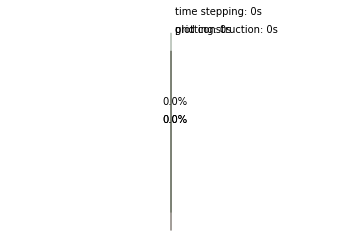

In [15]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

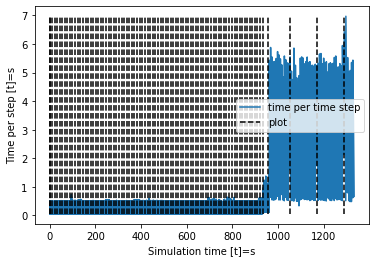

In [16]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

We first do an ls on our directory and search for the root .peano-patch-file. I then convert this file manually into vtu which I can load into Paraview. This works if Peano is configured with vtk support. If you don't have vtk support in there, then you might want to load the data directly into Paraview through Peano's Paraview plug-in.

In [17]:
!ls

AbstractCCZ4.cpp
AbstractCCZ4.h
AbstractCCZ4.o
C2P-FOCCZ4.f90
C2P-FOCCZ4.o
CCZ4.cpp
CCZ4.h
CCZ4.ipynb
ccz4-main.cpp
ccz4-main.h
ccz4-main.o
CCZ4.o
ccz4.py
celldata
Constants.h
EinsteinConstraints.f90
EinsteinConstraints.o
exahype.log-filter
facedata
gauge.ogv
MainVariables.f90
mainvariables.mod
MainVariables.o
Makefile
Metric.f90
Metric.o
observers
output.txt
PDE.f90
PDE.h
PDE.o
peano4
Properties.f90
Properties.h
Properties.o
repositories
solution-CCZ4.peano-patch-file
solution-CCZ4.pvd
solution-CCZ4-tree-0-0-rank-0.peano-patch-file
solution-CCZ4-tree-0-10-rank-0.peano-patch-file
solution-CCZ4-tree-0-11-rank-0.peano-patch-file
solution-CCZ4-tree-0-12-rank-0.peano-patch-file
solution-CCZ4-tree-0-13-rank-0.peano-patch-file
solution-CCZ4-tree-0-14-rank-0.peano-patch-file
solution-CCZ4-tree-0-15-rank-0.peano-patch-file
solution-CCZ4-tree-0-16-rank-0.peano-patch-file
solution-CCZ4-tree-0-17-rank-0.peano-patch-file
solution-CCZ4-tree-0-18-rank-0.peano-patch-file
solution-CCZ4-tree-0-19-rank-

# Visualisation

We have different ways how to visualise the outcome. If you have VTK support in your configure call, then Peano has built a vtk command line converter. 


Alternatively, start up Paraview

<pre>
export PYTHONPATH=../../../python
paraview
</pre>

and use Peano's visualisation routines through the Paraview Python terminal:


<pre>
import peano4.visualisation

output_files = "solution-CCZ4.peano-patch-file"
visualiser = peano4.visualisation.Visualiser( output_files )
visualiser.append_filter(peano4.visualisation.ExtractFineGridFilter())
visualiser.display()
</pre>

With !ls I see how many snapshots we've written:

In [18]:
!ls

AbstractCCZ4.cpp
AbstractCCZ4.h
AbstractCCZ4.o
C2P-FOCCZ4.f90
C2P-FOCCZ4.o
CCZ4.cpp
CCZ4.h
CCZ4.ipynb
ccz4-main.cpp
ccz4-main.h
ccz4-main.o
CCZ4.o
ccz4.py
celldata
Constants.h
EinsteinConstraints.f90
EinsteinConstraints.o
exahype.log-filter
facedata
gauge.ogv
MainVariables.f90
mainvariables.mod
MainVariables.o
Makefile
Metric.f90
Metric.o
observers
output.txt
PDE.f90
PDE.h
PDE.o
peano4
Properties.f90
Properties.h
Properties.o
repositories
solution-CCZ4.peano-patch-file
solution-CCZ4.pvd
solution-CCZ4-tree-0-0-rank-0.peano-patch-file
solution-CCZ4-tree-0-10-rank-0.peano-patch-file
solution-CCZ4-tree-0-11-rank-0.peano-patch-file
solution-CCZ4-tree-0-12-rank-0.peano-patch-file
solution-CCZ4-tree-0-13-rank-0.peano-patch-file
solution-CCZ4-tree-0-14-rank-0.peano-patch-file
solution-CCZ4-tree-0-15-rank-0.peano-patch-file
solution-CCZ4-tree-0-16-rank-0.peano-patch-file
solution-CCZ4-tree-0-17-rank-0.peano-patch-file
solution-CCZ4-tree-0-18-rank-0.peano-patch-file
solution-CCZ4-tree-0-19-rank-

The Paraview script class then allows me to switch to one of these snapshots:

<pre>
visualiser.select_dataset(9)
</pre>

Alternatively, I can ask the visualiser to convert the whole data series into a video and then open this output file. Invoke the call below and then load the resulting pvd file manually:

<pre>
visualiser.write_vtu_time_series()
</pre>

In [19]:
import peano4.visualisation
convert = peano4.visualisation.Convert( "solution-CCZ4", True )
convert.set_visualisation_tools_path( "../../../src/visualisation" )
convert.extract_fine_grid()
convert.convert_to_vtk()

ModuleNotFoundError: No module named 'paraview.simple'